In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.dates as mdates
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   datetime      341880 non-null  int64 
 1   datetime_iso  341880 non-null  object
 2   time-zone     341880 non-null  int64 
 3   temp          341880 non-null  object
 4   visibility    51112 non-null   object
 5   d_point       341880 non-null  object
 6   feels         341880 non-null  object
 7   min_temp      341880 non-null  object
 8   max_temp      341880 non-null  object
 9   prssr         341880 non-null  object
 10  sea_level     192964 non-null  object
 11  grnd_level    192919 non-null  object
 12  hum           341880 non-null  object
 13  wind_spd      341880 non-null  object
 14  wind_deg      341880 non-null  object
 15  rain_1h       341880 non-null  object
 16  rain_3h       192329 non-null  object
 17  snow_1h       192696 non-null  object
 18  snow_3h       192699 non

- `datetime` : Waktu ketika data dihitung (dalam format timestamp UNIX).
- `datetime_iso` : Waktu dalam format ISO 8601, termasuk zona waktu.
- `time-zone` : Zona waktu dalam detik terhadap UTC.
- `temp` : Suhu saat ini dalam Celcius. (C)
- `visibility` : Visibilitas rata-rata dalam meter. (m)
- `d_point` : Titik embun saat ini dalam Celcius. (C)
- `feels` : Suhu yang dirasakan saat ini dalam Celcius.(C)
- `min_temp` : Suhu minimum dalam rentang waktu tertentu dalam Celcius. (C)
- `max_temp` : Suhu maksimum dalam rentang waktu tertentu dalam Celcius. (C)
- `pressure` : Tekanan atmosfer dalam hPa . (hPa)
- `sea_level` : Tekanan atmosfer pada permukaan laut dalam hPa.(hPa)
- `grnd_level` : Tekanan atmosfer pada permukaan tanah dalam hPa.(hPa)
- `hum` : Persentase kelembaban udara saat ini.(%)
- `wind_spd` : Kecepatan angin saat ini dalam m/s. (m/s)
- `wind_deg` : Arah angin dalam derajat.(Derajat)
- `rain_1h` : Curah hujan dalam 1 jam terakhir dalam mm. (variabel target) (mm)
- `rain_3h` : Curah hujan dalam 3 jam terakhir dalam mm. (mm)
- `snow_1h` : Curah salju dalam 1 jam terakhir dalam mm. (mm)
- `snow_3h` : Curah salju dalam 3 jam terakhir dalam mm. (mm)
- `clouds` : Persentase penutupan awan saat ini.(%)

In [4]:
train.head(5)

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [5]:
def value_counts_check(df, columns):
    for column in columns:
        print(df[column].value_counts(),'\n---------------------\n')

def extract_string(column_input):
    if pd.isna(column_input):
        return None
    matches = re.findall(r'\d+\.\d+|\d+', column_input)
    if matches:
        return float(matches[0])
    else:
        return None
    
def remove_outliers_iqr(df, columns_to_check=None, factor=1.5):
    if columns_to_check is None:
        columns_to_check = df.columns

    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df[columns_to_check] < (Q1 - factor * IQR)) | (df[columns_to_check] > (Q3 + factor * IQR))).any(axis=1)

    df_filtered = df[mask]

    return df_filtered

def outliers_to_mean(df, columns_to_check=None, factor=1.5, replace_with_nan=True):
    if columns_to_check is None:
        columns_to_check = df.columns

    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    if replace_with_nan:
        # Create a mask to identify outliers and replace them with NaN
        outlier_mask = ((df[columns_to_check] < (Q1 - factor * IQR)) | (df[columns_to_check] > (Q3 + factor * IQR)))
        df[outlier_mask] = np.nan
    
    # Fill NaN values with the mean of their respective columns
    df_filled = df.fillna(df.mean())

    return df_filled

def outliers_to_median(df, columns_to_check=None, factor=1.5, replace_with_nan=True):
    if columns_to_check is None:
        columns_to_check = df.columns

    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    if replace_with_nan:
        # Create a mask to identify outliers and replace them with NaN
        outlier_mask = ((df[columns_to_check] < (Q1 - factor * IQR)) | (df[columns_to_check] > (Q3 + factor * IQR)))
        df[outlier_mask] = np.nan
    
    # Fill NaN values with the mean of their respective columns
    df_filled = df.fillna(df.median())

    return df_filled

def plotTimeSeries(dataset, feature_name):
    _ = plt.rcParams['figure.figsize'] = (15, 5)
    _ = plt.grid(which = 'major', c = '#cccccc', alpha = 0.5)
    _ = plt.scatter(dataset.index, dataset[feature_name],
                    marker = 'o', s = 0.1, alpha = 0.5,
                    color = 'blue')
    _ = plt.title(feature_name, family = 'Arial', fontsize = 16)
    _ = plt.xlabel('Timestamp [Date Time]', family = 'Arial', fontsize = 14)
    _ = plt.ylabel(feature_name, family = 'Arial', fontsize = 14)
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(fontsize = 14)
    _ = plt.show()
                  
    return None

def plotDistribution(dataset, feature_name):
    plt.rcParams['figure.figsize'] = (15, 5)
    sns.histplot(dataset[feature_name], kde=True, color='blue', bins=30)
    plt.title(f'{feature_name} Distribution', family='Arial', fontsize=16)
    plt.xlabel(feature_name, family='Arial', fontsize=14)
    plt.ylabel('Frequency', family='Arial', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [6]:
columns_to_check = ['time-zone', 'visibility', 'sea_level', 'grnd_level', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']

value_counts_check(train, columns_to_check)

time-zone
28800    341880
Name: count, dtype: int64 
---------------------

visibility
unrecognized    4352
-1m             4349
unknown         4326
-1km            4278
unidentified    4263
-1 km           4263
-1              4257
                4241
undefined       4238
-1 m            4234
missing         4165
empty           4146
Name: count, dtype: int64 
---------------------

sea_level
undetermined     154582
-1                 4890
unestablished      4823
unsettled          4809
not_recorded       4804
not-recorded       4803
unknown            4792
not recorded       4735
unspecified        4726
Name: count, dtype: int64 
---------------------

grnd_level
undetermined     148814
not recorded       5615
not_recorded       5579
unspecified        5537
-1                 5511
unsettled          5497
not-recorded       5480
unknown            5443
unestablished      5443
Name: count, dtype: int64 
---------------------

rain_1h
0          169494
            21290
0 mm         5

In [7]:
train_dp = train.copy()

In [8]:
replace_vis = {
    'unrecognized': np.nan,
    'unidentified': np.nan,
    'undefined': np.nan,
    'missing': np.nan,
    'unknown': np.nan,
    'empty': np.nan,
    ' ': np.nan,
    '-1m': 1,
    '-1km': 1000,
    '-1 km': 1000,
    '-1': 1,
    '-1 m': 1
}

train_dp['visibility'] = train_dp['visibility'].replace(replace_vis)

In [9]:
train_dp['visibility'].value_counts()

visibility
1.0       12840
1000.0     8541
Name: count, dtype: int64

In [10]:
columns_to_extract = ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'hum', 'wind_spd', 'wind_deg', 'rain_1h', 'clouds']

for column in columns_to_extract:
    train_dp[column] = train_dp[column].apply(lambda x: extract_string(x))

In [11]:
train_dp['datetime'] = pd.to_datetime(train_dp['datetime'], unit = 's')
train_dp['datetime_iso'] = pd.to_datetime(train_dp['datetime_iso'], format='%Y-%m-%d %H:%M:%S%z')

print(train_dp['datetime'].dtype)
print(train_dp['datetime_iso'].dtype)

datetime64[ns]
datetime64[ns, UTC]


In [12]:
train_dp.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,1979-01-01 00:00:00,1979-01-01 00:00:00+00:00,28800,24.75,NaN,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,NaN,0,NaN,NaN,100.0
1,1979-01-01 01:00:00,1979-01-01 01:00:00+00:00,28800,24.58,NaN,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0,0,0,100.0
2,1979-01-01 02:00:00,1979-01-01 02:00:00+00:00,28800,26.60,NaN,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,volume:zero,NaN,NaN,99.0
3,1979-01-01 03:00:00,1979-01-01 03:00:00+00:00,28800,27.31,NaN,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,nol,0,NaN,94.0
4,1979-01-01 04:00:00,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,nol,NaN,0,100.0


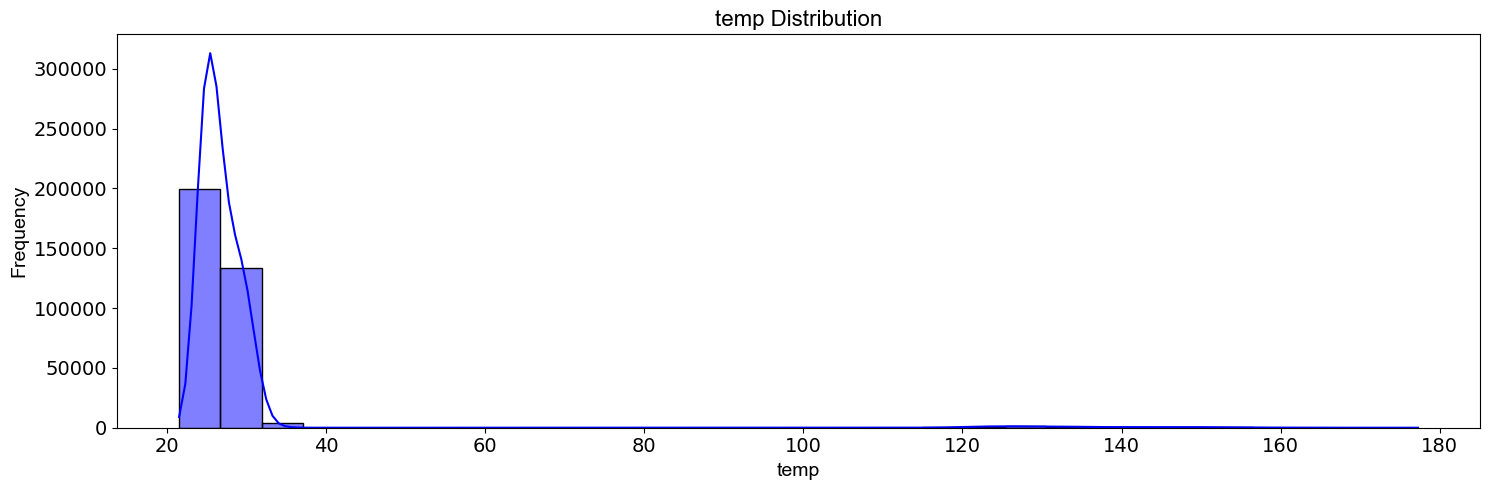

In [13]:
plotDistribution(train_dp, 'temp')

In [14]:
train_dp.columns

Index(['datetime', 'datetime_iso', 'time-zone', 'temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_1h', 'rain_3h',
       'snow_1h', 'snow_3h', 'clouds'],
      dtype='object')

In [15]:
non_numeric_cols = ['datetime', 'datetime_iso', 'time-zone', 'visibility', 'sea_level', 'grnd_level', 'rain_3h', 'snow_1h', 'snow_3h']

In [16]:
train_dp_numeric = train_dp.drop(non_numeric_cols, axis = 1)

In [17]:
noOutliersTrain = remove_outliers_iqr(train_dp_numeric)
meanOutliersTrain = outliers_to_mean(train_dp_numeric)
medianRain = outliers_to_median(train_dp_numeric)

In [18]:
medianRain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      341880 non-null  float64
 1   d_point   341880 non-null  float64
 2   feels     341880 non-null  float64
 3   min_temp  341880 non-null  float64
 4   max_temp  341880 non-null  float64
 5   prssr     341880 non-null  float64
 6   hum       341880 non-null  float64
 7   wind_spd  341880 non-null  float64
 8   wind_deg  341880 non-null  float64
 9   rain_1h   341880 non-null  float64
 10  clouds    341880 non-null  float64
dtypes: float64(11)
memory usage: 28.7 MB


In [46]:
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler() 
data_scaled = scaler.fit_transform(train_dp.drop(non_numeric_cols, axis = 1))
scaled_df = pd.DataFrame(data_scaled, columns=train_dp.drop(non_numeric_cols, axis = 1).columns)
scaled_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
0,-0.425220,-0.527132,-0.120596,-0.353982,-0.613772,1.0,0.230769,-0.489130,0.900000,NaN,0.157895
1,-0.475073,-0.651163,-0.146341,-0.439528,-0.601796,1.0,0.230769,-0.336957,1.038462,0.000000,0.157895
2,0.117302,-0.395349,-0.006775,0.182891,0.035928,1.0,-0.461538,-0.054348,1.046154,0.000000,0.105263
3,0.325513,-0.155039,0.575881,0.327434,0.326347,1.0,-0.615385,-0.206522,1.069231,0.448276,-0.157895
4,0.354839,0.372093,0.662602,0.324484,0.311377,0.5,-0.384615,-0.445652,1.023077,1.172414,0.157895


In [50]:
train_dp_numeric['rain_1h'] = train_dp_numeric['rain_1h'].fillna(train_dp_numeric['rain_1h'].mean())

In [51]:
train_final = pd.concat([meanOutliersTrain, train_dp_numeric['rain_1h']], axis = 1)

In [52]:
train_final.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,rain_1h
0,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,100.0,0.089673
1,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,100.0,0.000000
2,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,99.0,0.000000
3,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,94.0,0.130000
4,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,100.0,0.340000


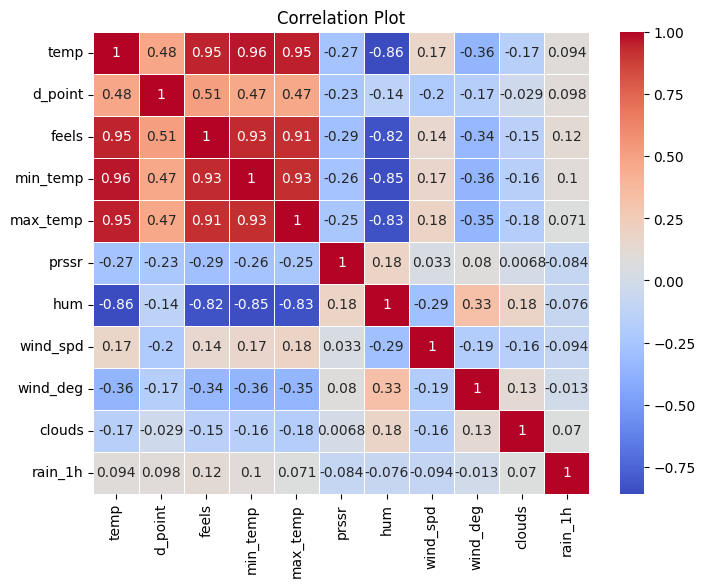

In [75]:
# Calculate the correlation matrix
correlation_matrix = train_final.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [53]:
train_final.isna().sum()

temp        0
d_point     0
feels       0
min_temp    0
max_temp    0
prssr       0
hum         0
wind_spd    0
wind_deg    0
clouds      0
rain_1h     0
dtype: int64

In [54]:
noOutliersTrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211890 entries, 0 to 341879
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      211890 non-null  float64
 1   d_point   211890 non-null  float64
 2   feels     211890 non-null  float64
 3   min_temp  211890 non-null  float64
 4   max_temp  211890 non-null  float64
 5   prssr     211890 non-null  float64
 6   hum       211890 non-null  float64
 7   wind_spd  211890 non-null  float64
 8   wind_deg  211890 non-null  float64
 9   rain_1h   193322 non-null  float64
 10  clouds    211890 non-null  float64
dtypes: float64(11)
memory usage: 19.4 MB


In [55]:
meanOutliersTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      341880 non-null  float64
 1   d_point   341880 non-null  float64
 2   feels     341880 non-null  float64
 3   min_temp  341880 non-null  float64
 4   max_temp  341880 non-null  float64
 5   prssr     341880 non-null  float64
 6   hum       341880 non-null  float64
 7   wind_spd  341880 non-null  float64
 8   wind_deg  341880 non-null  float64
 9   clouds    341880 non-null  float64
dtypes: float64(10)
memory usage: 26.1 MB


In [56]:
noOutliersTrain.to_csv('data/train_noOutliers.csv', index = False)

In [57]:
medianRain.to_csv('data/train_med.csv', index=False)

In [58]:
medianRain[medianRain['rain_1h'] != 0.0]

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
3,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,94.0
4,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,100.0
9,26.38,24.97,26.38,25.68,29.02,1009.0,92.0,0.44,294.0,0.39,92.0
10,25.42,25.08,26.58,24.76,26.02,1009.0,98.0,0.63,36.0,0.21,87.0
11,25.19,25.02,26.35,24.50,25.68,1010.0,99.0,0.78,10.0,0.21,95.0
...,...,...,...,...,...,...,...,...,...,...,...
341859,29.47,24.79,35.12,28.80,30.17,1011.0,76.0,1.68,202.0,0.14,99.0
341860,29.80,23.74,34.56,28.99,30.50,1010.0,70.0,1.62,320.0,0.19,100.0
341868,27.55,25.19,31.93,27.07,28.50,1007.0,87.0,1.39,149.0,0.20,98.0
341878,26.68,24.71,29.76,25.02,27.25,1008.0,89.0,1.46,17.0,0.30,98.0


In [59]:
filtered_data = medianRain[medianRain['rain_1h'] != 0.0]

In [61]:
median_filtered = outliers_to_mean(filtered_data)

C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_27388\3419894591.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[outlier_mask] = np.nan
C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_27388\3419894591.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[outlier_mask] = np.nan


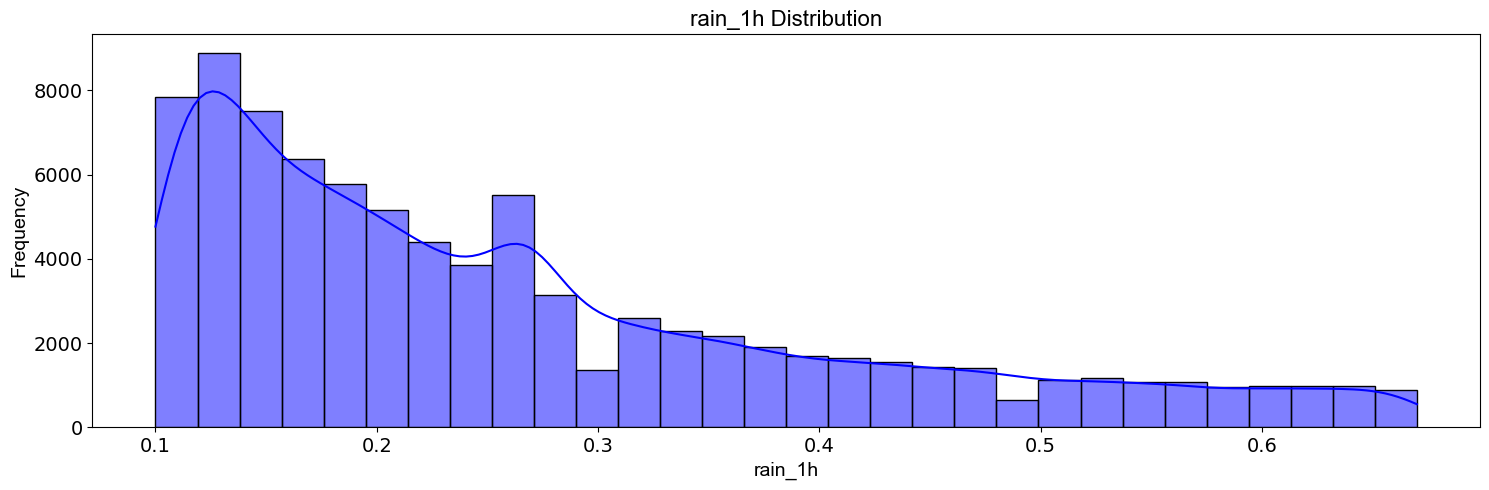

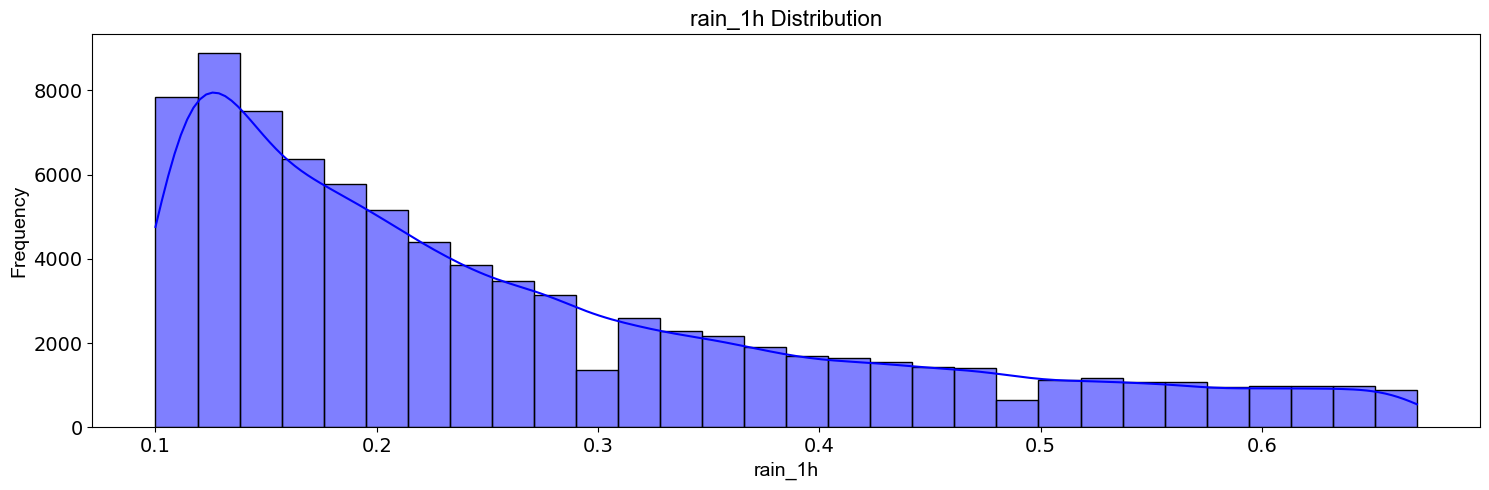

In [63]:
plotDistribution(median_filtered, 'rain_1h')
plotDistribution(filtered_data, 'rain_1h')

In [64]:
median_filtered.isna().sum()

temp        0
d_point     0
feels       0
min_temp    0
max_temp    0
prssr       0
hum         0
wind_spd    0
wind_deg    0
rain_1h     0
clouds      0
dtype: int64

In [ ]:
median_filtered.to_csv('data/train_med_filtered.csv', index = False)

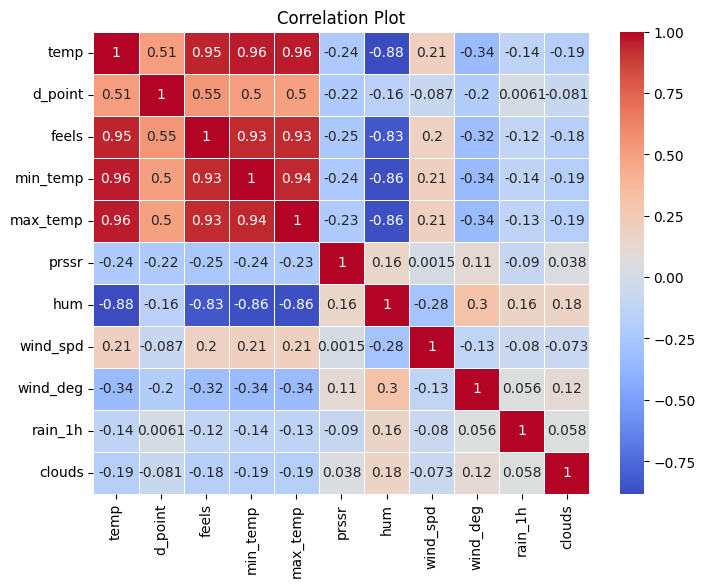

In [65]:
# Calculate the correlation matrix
correlation_matrix = median_filtered.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [67]:
train_dp['rain_1h'].max()

27.1

In [68]:
test = pd.read_csv('data/test.csv')

In [69]:
test.head()
test_dp = test.copy()

In [70]:
columns_to_extract_test = ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'hum', 'wind_spd', 'wind_deg', 'clouds']

for column in columns_to_extract_test:
    test_dp[column] = test_dp[column].apply(lambda x: extract_string(x))

In [71]:
test_dp.columns

Index(['datetime', 'datetime_iso', 'time-zone', 'temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds'],
      dtype='object')

In [ ]:
train_final.columns

Index(['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'hum',
       'wind_spd', 'wind_deg', 'clouds', 'rain_1h'],
      dtype='object')

In [72]:
test_drop_cols = ['datetime', 'time-zone', 'visibility', 'sea_level','grnd_level', 'rain_3h','snow_1h', 'snow_3h']

test_dp = test_dp.drop(test_drop_cols, axis = 1)
test_dp.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0


In [73]:
test_dp.to_csv('data/test_dp.csv', index = False)

In [40]:
meanOutliersTest = outliers_to_mean(test_dp.drop('datetime_iso', axis = 1))

In [42]:
test_final = pd.concat([test_dp['datetime_iso'], meanOutliersTest], axis = 1)
test_final.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0


In [44]:
test_final.to_csv('data/test_prep.csv', index = False)

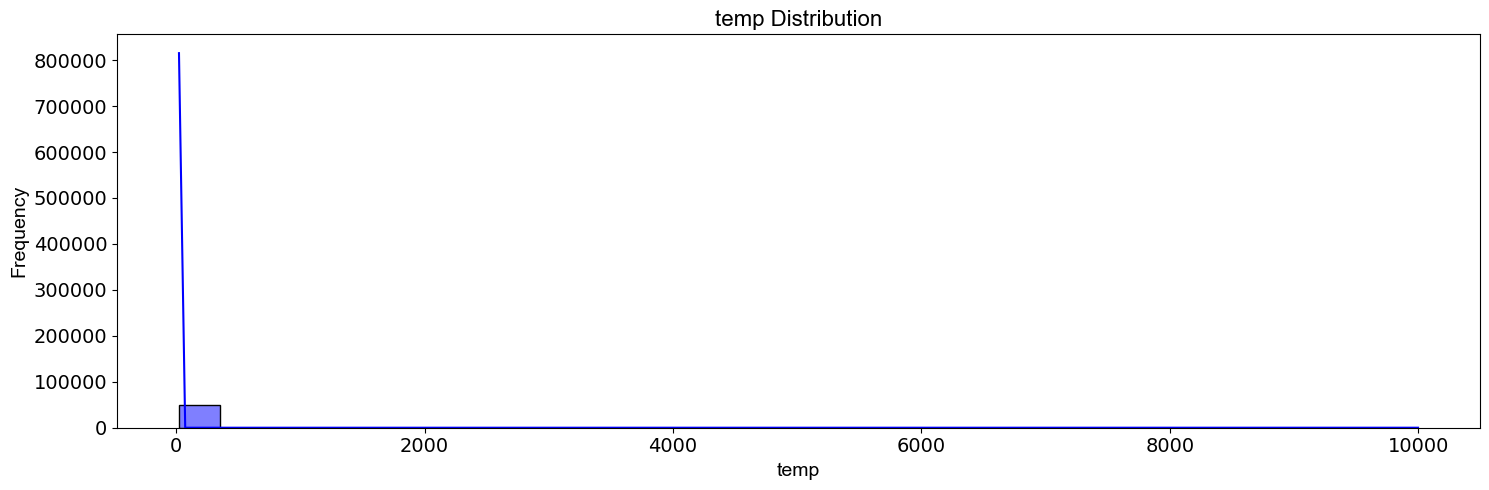

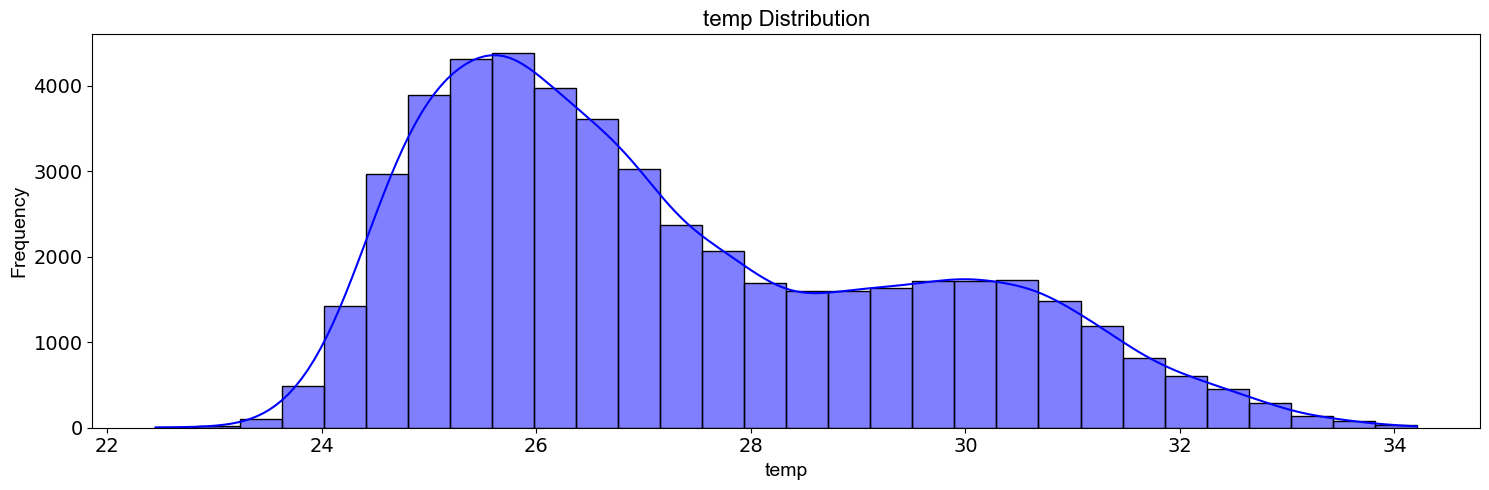

In [43]:
plotDistribution(test_dp, 'temp')
plotDistribution(test_final, 'temp')